# 1. Environment Setup

In [66]:
%pip install urllib3 xarray numpy pandas tqdm pillow matplotlib plotly seaborn scikit-learn 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Data Formatting
import urllib.request
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import os
from PIL import Image

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Data Processing
from sklearn.linear_model import LinearRegression
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. PCA Model

$$\text{Original Components} = \text{Height x Width x Number of Channels}$$
$$\text{PCA Components} = n_{\text{components}}$$
$$\text{Reduction Ratio} = \frac{n_{\text{pca}}}{n_{\text{original}}}

# 2. Regression (Precipitation Forcasting)



In [68]:
# Directory containing the images
image_dir = 'monthly_precipitation_maps'

# Load image file names and extract dates
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
dates = [f.split('_')[1].split('.')[0] for f in image_files]

# Convert dates to numerical format (e.g., YYYYMM to integer)
from datetime import datetime
date_objects = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
y = np.array([int(date.strftime("%Y%m")) for date in date_objects])

def load_images(image_dir, image_files):
    images = []
    for file in tqdm(image_files):
        img_path = os.path.join(image_dir, file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((500, 350))  # Resize images to match input size of CNN
        img_array = np.array(img) / 255.0 # Normalize pixel values
        images.append(img_array)
    return np.array(images)

X = load_images(image_dir, image_files)

100%|██████████| 72/72 [00:01<00:00, 53.19it/s]


In [69]:
# PCA Model
n_components = 10  # Principal components: TEST DIFFERENT VALUES
pca = PCA(n_components=n_components)

# Get image dimensions
n_samples, img_height, img_width, n_channels = X.shape

# Flatten the images
X_flattened = X.reshape(n_samples, -1)

# Apply PCA
X_pca = pca.fit_transform(X_flattened)

# Reconstruct the images from the PCA components
X_reconstructed = pca.inverse_transform(X_pca)

# Reshape the reconstructed images to their original dimensions
X_reconstructed = X_reconstructed.reshape(n_samples, img_height, img_width, n_channels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


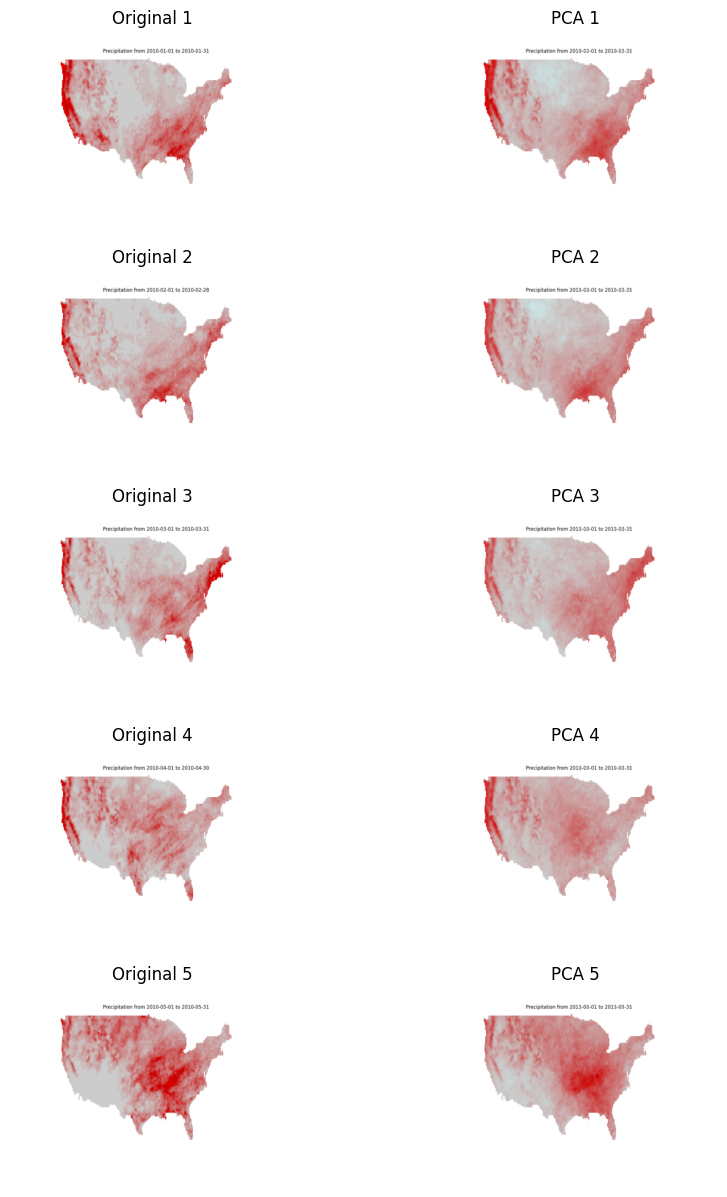

In [70]:
# Plot original and reconstructed images for comparison
n_images_to_display = 5
fig, axes = plt.subplots(n_images_to_display, 2, figsize=(10, 15))

for i in range(n_images_to_display):
    # Original image
    axes[i, 0].imshow(X[i])
    axes[i, 0].set_title(f'Original {i+1}')
    axes[i, 0].axis('off')
    
    # Reconstructed image
    axes[i, 1].imshow(X_reconstructed[i])
    axes[i, 1].set_title(f'PCA {i+1}')
    axes[i, 1].axis('off')

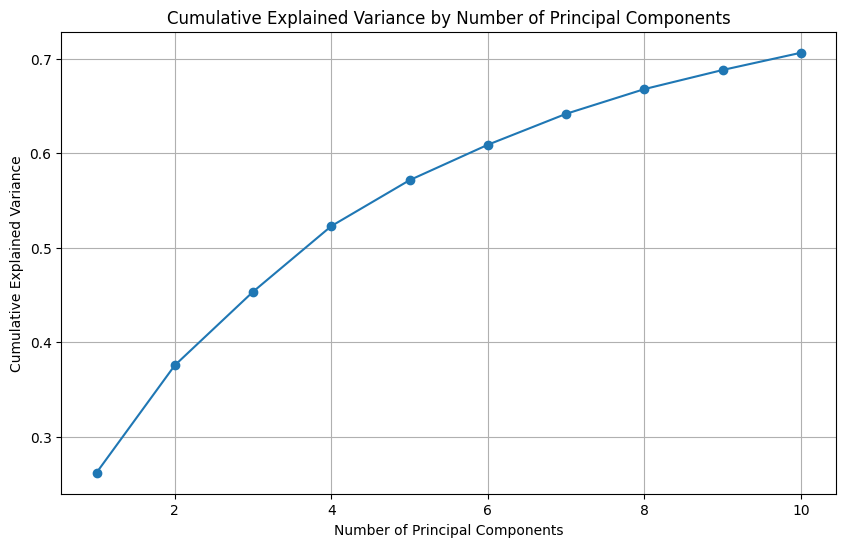

In [71]:
# Explained variance plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# 3. Classification (MNIST)

In [72]:
# Load and preprocess the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [73]:
def plot_performance(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [74]:
def evaluate_accuracy(model, x_test, y_test, model_name):
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_accuracy * 100:.2f}%")
    return test_accuracy

In [75]:
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

In [76]:
# Apply PCA
n_components = 100  # Principal components: TEST DIFFERENT VALUES
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

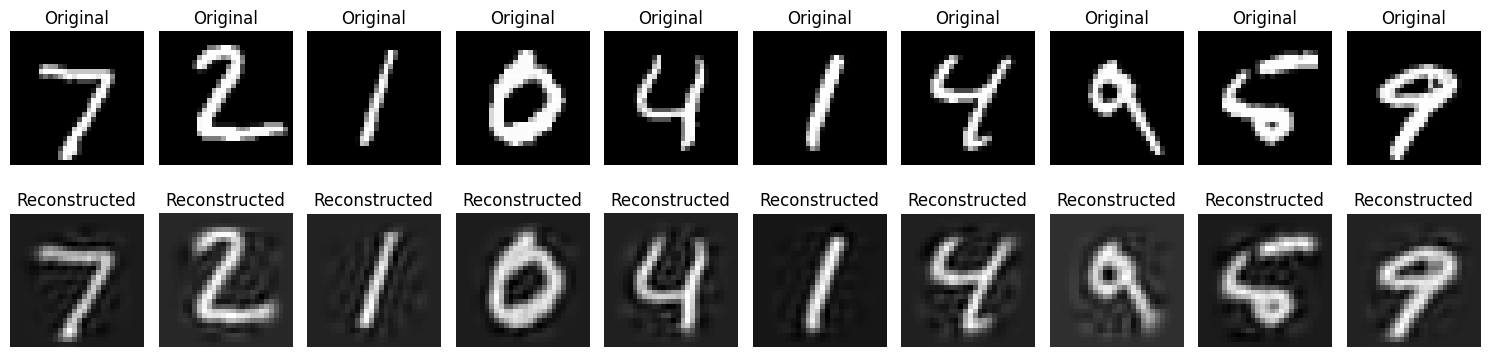

In [77]:
# Visualize reconstructed images from PCA
def plot_reconstructed_images(original, transformed, pca_model, num_images=10):
    """Reconstruct and plot the original and PCA-reconstructed images."""
    reconstructed = pca_model.inverse_transform(transformed)
    reconstructed_images = reconstructed.reshape(-1, 28, 28)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(original[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot original and reconstructed images
plot_reconstructed_images(x_test, x_test_pca, pca)

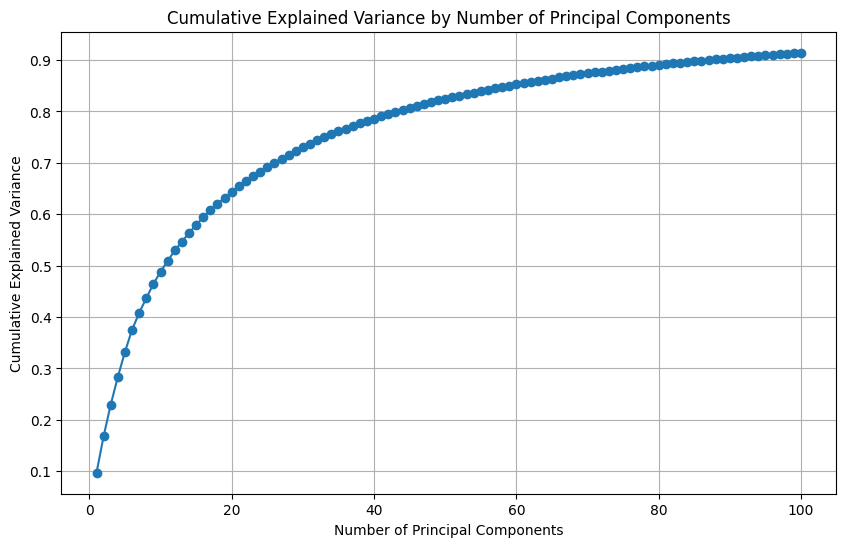

In [78]:
# Explained variance plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()